# Evaluation

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

## Insight in the training process

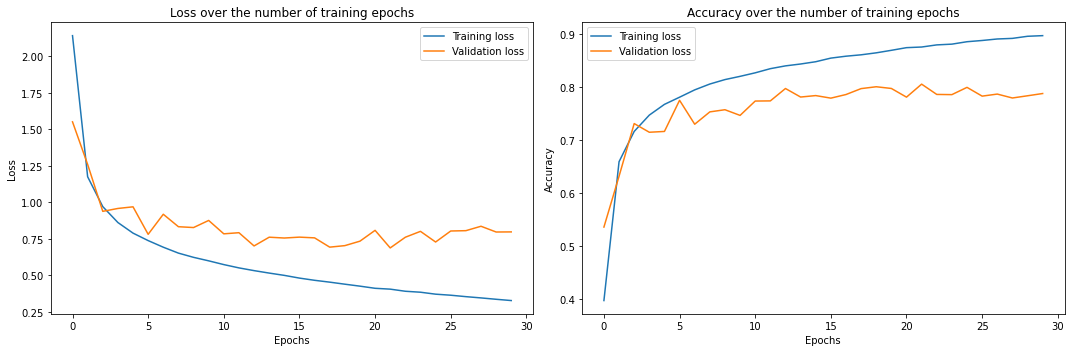

In [78]:
# Fetch training history
training_history = np.load("../results/baseline_(resnet15)_training_history.npy", allow_pickle=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Plot loss results
ax1.plot(training_history.item().get("loss"), label="Training loss")
ax1.plot(training_history.item().get("val_loss"), label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss over the number of training epochs")
ax1.legend()

# Plot accuracy results
ax2.plot(training_history.item().get("accuracy"), label="Training loss")
ax2.plot(training_history.item().get("val_accuracy"), label="Validation loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy over the number of training epochs")
ax2.legend()

plt.tight_layout()
plt.show()

## Performance on test data

In [3]:
def process_predictions(test_predictions, test_labels, one_hot_mapping):
    predictions = []
    labels = []

    for pred, label in zip(test_predictions, test_labels):
        pred_index = np.argmax(pred)
        predictions.append(one_hot_mapping[pred_index])

        truth_index = np.argmax(label)
        labels.append(one_hot_mapping[truth_index])
        
    return predictions, labels    

In [81]:
# Load test predictions
test_predictions = np.load("../results/baseline_(resnet15)_predictions.npy")

# Load test labels
test_labels = np.load("../results/baseline_(resnet15)_test_labels.npy")

# Load one-hot-mapping
one_hot_mapping = np.load("one_hot_mapping.npy", allow_pickle=True)

In [82]:
# Process predictions to their original labels
predictions, labels = process_predictions(test_predictions, test_labels, one_hot_mapping)

In [83]:
# Show the classification report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

    backward       0.80      0.92      0.85       167
         bed       0.81      0.64      0.71       201
        bird       0.56      0.87      0.68       206
         cat       0.64      0.78      0.70       203
         dog       0.88      0.54      0.67       213
        down       0.87      0.71      0.78       392
       eight       0.82      0.87      0.84       378
        five       0.89      0.64      0.74       405
      follow       0.89      0.47      0.62       158
     forward       0.51      0.87      0.64       156
        four       0.84      0.74      0.79       373
          go       0.66      0.69      0.67       388
       happy       0.79      0.84      0.81       205
       house       0.74      0.90      0.81       211
       learn       0.65      0.65      0.65       158
        left       0.82      0.85      0.83       380
      marvin       0.90      0.56      0.69       210
        nine       0.92    

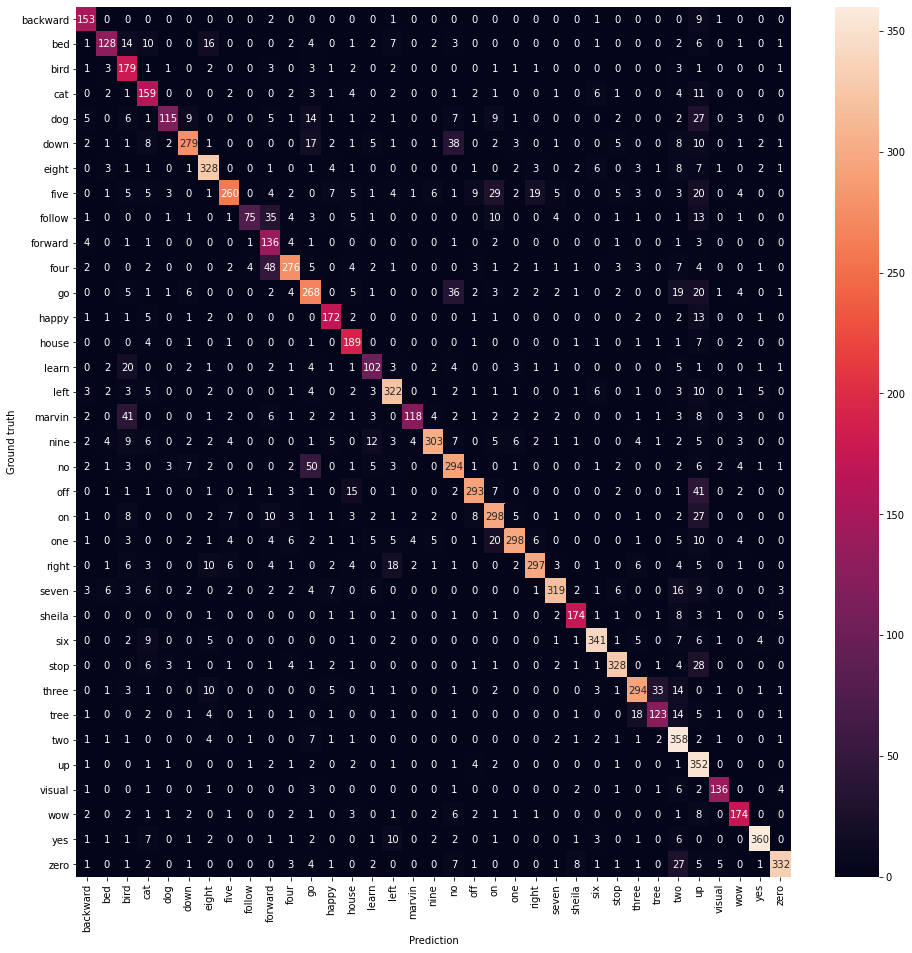

In [84]:
# Construct and show confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

plt.figure(figsize = (16,16))
sn.heatmap(conf_matrix, annot=True, xticklabels=one_hot_mapping, yticklabels=one_hot_mapping, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
plt.show()

In [85]:
fnr_all = dict()
fpr_all = dict()
roc_auc = dict()

for i in range(35):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    fnr = 1 - tpr
    
    # store results
    fnr_all[i] = fnr
    fpr_all[i] = fpr
    
# Compute micro results
micro_fpr, micro_tpr, _ = roc_curve(test_labels.ravel(), test_predictions.ravel())
micro_fnr = 1 - micro_tpr
fnr_all['micro'] = micro_fnr
fpr_all['micro'] = micro_fpr
auc(fpr_all["micro"], fnr_all["micro"])

0.009648116836132595

In [76]:
fpr_all["micro"][5000:10000]

array([0.02305029, 0.02305029, 0.02305307, ..., 0.41791775, 0.41791775,
       0.41815676])

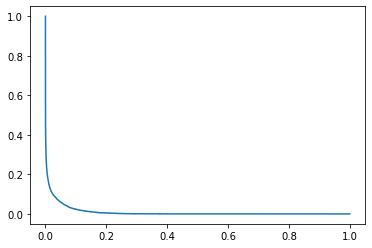

In [86]:
plt.plot(fpr_all['micro'], fnr_all['micro'])

In [58]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(35):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), test_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(35)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(35):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 35

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [59]:
roc_auc["macro"]

0.9773432071814264

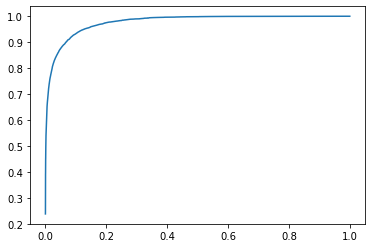

In [60]:
plt.plot(fpr['macro'], tpr['macro'])

In [92]:
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(np.mean(FAR))
print(np.mean(FRR))

0.0062632419050872145
0.22034412984141924


In [95]:
np.mean(micro_fnr)

0.18489033102702945